In [60]:
## Use SVM and SGD to attempt to model and predict the class of an internet connection request.
## Import Necessary Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [61]:
#load data
df = pd.read_csv('log2.csv')
df = df.round(5)
df.info()
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000
mean,49391.96934,10577.38581,19282.97276,2671.04993,97123.95009,22385.79691,74738.15318,102.86603,65.83358,41.39953,61.46650
std,15255.71254,18466.02704,21970.68967,9739.16228,5618438.90905,3828138.64979,2463207.71188,5133.00235,302.46176,3218.87129,2223.33227
min,0.00000,0.00000,0.00000,0.00000,60.00000,60.00000,0.00000,1.00000,0.00000,1.00000,0.00000
25%,49183.00000,80.00000,0.00000,0.00000,66.00000,66.00000,0.00000,1.00000,0.00000,1.00000,0.00000
50%,53776.50000,445.00000,8820.50000,53.00000,168.00000,90.00000,79.00000,2.00000,15.00000,1.00000,1.00000
75%,58638.00000,15000.00000,38366.25000,443.00000,752.25000,210.00000,449.00000,6.00000,30.00000,3.00000,2.00000
max,65534.00000,65535.00000,65535.00000,65535.00000,1269359015.00000,948477220.00000,320881795.00000,1036116.00000,10824.00000,747520.00000,327208.00000


In [62]:
## Visualize missingness 
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = df.isnull().sum() * 100 / len(df)
#Put percents into df 
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
#Sort it and show the results
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Source Port,Source Port,0.0
Destination Port,Destination Port,0.0
NAT Source Port,NAT Source Port,0.0
NAT Destination Port,NAT Destination Port,0.0
Action,Action,0.0
Bytes,Bytes,0.0
Bytes Sent,Bytes Sent,0.0
Bytes Received,Bytes Received,0.0
Packets,Packets,0.0
Elapsed Time (sec),Elapsed Time (sec),0.0


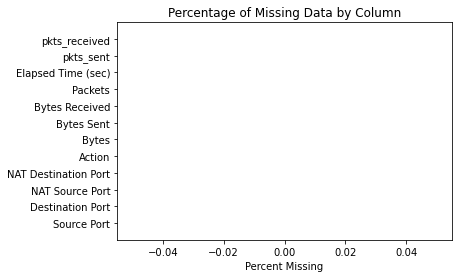

In [63]:
# Create bar chart of missing data percentages
plt.barh(missing_value_df['column_name'], missing_value_df['percent_missing'])

# Add labels and title
plt.xlabel('Percent Missing')
plt.title('Percentage of Missing Data by Column')

# Display the graph
plt.show()

In [64]:
## no missing data. Good

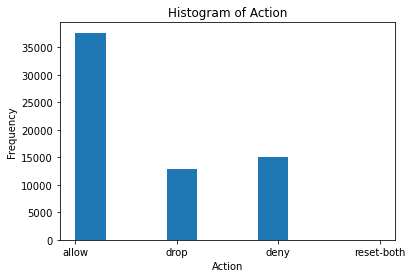

In [65]:
## the response variable is action graph to look at our actions
plt.hist(df['Action'])
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Histogram of Action')
plt.show()

In [66]:
df['Action'].value_counts(normalize=False)


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [67]:
target_mod = {
    'allow':'allow',
    'deny':'deny',
    'drop':'deny',
    'reset-both':'deny'
}

df.loc[df['Action'].isin(target_mod.keys()), 'Action_Revision'] = df['Action'].map(target_mod)
df.drop('Action', axis=1, inplace=True)
df['Action_Revision'] = df['Action_Revision'].astype('category')


In [68]:
df['Action_Revision'].value_counts(normalize=False)


allow    37640
deny     27892
Name: Action_Revision, dtype: int64

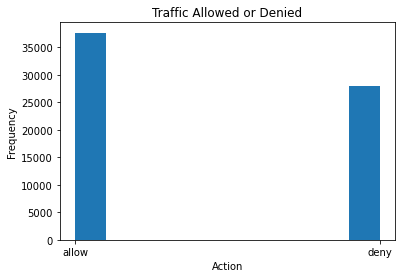

In [69]:
## the response variable is action graph to look at our actions
plt.hist(df['Action_Revision'])
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Traffic Allowed or Denied')
plt.show()

We have two values in our response variable now. This will aid us with accuracy and the algorithims will only have to differentiate between two calues. We can beat overfitting this way. 

In [70]:
print(df)

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0            57222                53            54587                    53   
1            56258              3389            56258                  3389   
2             6881             50321            43265                 50321   
3            50553              3389            50553                  3389   
4            50002               443            45848                   443   
...            ...               ...              ...                   ...   
65527        63691                80            13237                    80   
65528        50964                80            13485                    80   
65529        54871               445                0                     0   
65530        54870               445                0                     0   
65531        54867               445                0                     0   

         Bytes  Bytes Sent  Bytes Received  Packets